## 预处理
导入Tab Delimited File 文献集格式，进行预处理

In [1]:
from paper_preprocess import preprocess_main
file_paths = [
    'test_files\\savedrecs_UD_RL_1-1000.txt',
    'test_files\\savedrecs_UD_RL_1001-1346.txt'
]

papers = preprocess_main(file_paths)


加载的文献总数量: 2346
移除重复后的文献数量: 1303
删除2010年前文献后数量: 1303
Word: control, Frequency: 354
Word: [arxiv], Frequency: 131
Word: planning, Frequency: 130
Word: adaptive, Frequency: 106
Word: decision, Frequency: 96
Word: connected, Frequency: 90
Word: learning-based, Frequency: 90
Word: traffic, Frequency: 88
Word: framework, Frequency: 81
Word: decision-making, Frequency: 79
Word: via, Frequency: 77
Word: energy, Frequency: 73
Word: path, Frequency: 72
Word: electric, Frequency: 70
Word: trajectory, Frequency: 68
Word: dynamic, Frequency: 67
Word: intelligent, Frequency: 67
Word: multi-agent, Frequency: 65
Word: safety, Frequency: 65
Word: management, Frequency: 65


In [2]:
# 另一个文件，cite排序后的
file_paths = ['output\\savedrecs_UDRL_SortCitations_tagged.txt']
from paper_preprocess import preprocess_main
papers = preprocess_main(file_paths,latest_year=2016)

加载的文献总数量: 884
移除重复后的文献数量: 842
删除2016年前文献后数量: 842
Word: control, Frequency: 161
Word: planning, Frequency: 65
Word: [arxiv], Frequency: 59
Word: electric, Frequency: 54
Word: adaptive, Frequency: 49
Word: decision, Frequency: 44
Word: energy, Frequency: 44
Word: learning-based, Frequency: 43
Word: management, Frequency: 42
Word: traffic, Frequency: 39
Word: framework, Frequency: 38
Word: decision-making, Frequency: 37
Word: path, Frequency: 37
Word: via, Frequency: 36
Word: dynamic, Frequency: 35
Word: connected, Frequency: 34
Word: hybrid, Frequency: 33
Word: trajectory, Frequency: 33
Word: multi-agent, Frequency: 31
Word: intelligent, Frequency: 30


导入代理、API、模型选择等llm相关的参数

In [1]:
from llm_chain import llmConfig, get_chain_prompt_classifier, get_chain_paper_tagging
from toolbox import get_conf
proxies, API_KEY,LLM_MODEL = get_conf('proxies', 'API_KEY','LLM_MODEL')
llmconfig = llmConfig(openai_api_key=API_KEY, openai_proxy=proxies['http'], model_name=LLM_MODEL)
llmconfig.temperature = 0


C:\Users\24760\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 [PROXY] 网络代理状态：已配置。配置信息如下： {'http': 'http://127.0.0.1:22307', 'https': 'http://127.0.0.1:22307'} 
 [API_KEY] 您的 API_KEY 是: sk-WvRifNrh6spf*** API_KEY 导入成功 


显示词云与文章数量-发表年图：

![word_cloud](output/wordcloud.png)

强化学习在自动（无人，智能）驾驶领域应用，首先最多的是控制部分，action, control 应该是对应着执行的部分。当然这个控制也可能是规划方面的交通流控制、行动选择等。

然后是规划决策阶段，decision making, planning, 是决策阶段的一部分，其他的有更宏观的traffic、navigation、agent

action部分可以更细分到PTC、VDC，甚至横向动力学、轨迹跟踪、稳定性

planning部分可以细分到任务决策、路径规划



![year-publishes.png](output/year-publishes.png)

这个曲线很符合ML+any的趋势。相关文章爆发时增长


接下来，我们需要关心具体的方法

强化学习方法在无人车控制领域，可以分为哪几类？

分别使用了哪算模型or算法

## 文献分类
首先根据已有知识对methods和domain给一个集合。了解不多可以直接问GPT。
尝试过通过给GPT文献库所有标题让它分析可能的methods和domain，但是效果不太好，不如直接给两个关键词让他尝试给methods方法与domain领域。
例如这里给的就是RL算法的细分方法，与自动驾驶规划与控制的细分领域。

注意！！：分类效果很大程度上取决于你的划分方法，并且很容易出现错误，如果之后用作参考文献还需要人工检查。

In [9]:
methods = [
"Deep Q-Learning", 
"Dueling DQN",  # 决斗DQN
"Double DQN",  # 双重DQN
"Actor Critic",  # 演员批判家方法
"Q-Learning",  # Q学习
"Policy Gradient",  # 策略梯度
"A3C (Asynchronous Advantage Actor-Critic)",  # 异步优势演员批判家
"DDPG (Deep Deterministic Policy Gradient)",  # 深度确定性策略梯度
"TRPO (Trust Region Policy Optimization)",  # 信任区域策略优化
"PPO (Proximal Policy Optimization)",  # 近端策略优化
"SAC (Soft Actor-Critic)",  # 软演员批判家
"Twin Delayed DDPG (TD3)",  # 双延迟深度确定性策略梯度
"HER (Hindsight Experience Replay)"  # 追忆经验回放
]

domains = [
"Motion Planning",  # 运动规划
"Behavior Decision",  # 行动选择（包括变道、转向等）
"Local Path Planning",  # 局部路径规划
"Velocity Control",  # 纵向控制（速度保持、加速等）
"Lateral Control",  # 横向控制（轨迹跟踪、稳定性控制等）
"Attitude Control",  # 姿态控制（主要涉及稳定性）
"Trajectory Optimization",  # 轨迹优化
"Dynamic Obstacle Avoidance",  # 动态障碍物避让
"Risk Assessment",  # 风险评估
"Map Integration",  # 地图集成（将车辆感知与地图数据相结合以支持规划和导航）
"Vehicle-to-Everything (V2X) Communication",  # 车辆至一切(V2X)通信（用于提高预测准确性和决策的合理性）
]

这里可以通过prompt的方法。这种方法用GPT3.5经常会出错，结果几乎不可用，但是GPT4的效果会好很多。
效果不满意可以精调prompt，修改比较容易

In [5]:
chain = get_chain_prompt_classifier(llmconfig, methods, domains)


或者使用function calling 的方法，会调用openai_schema = pydantic_schema.schema() 这个function。这种方法的好处是能生成更加准确的输出，但是对于一些综述或多methods、多domains的文献无法准确识别,记过不满意也不好调整

![function_calling](document/schema_function_calling.png)

In [6]:
schema = {
    "properties": {
        "method": {
            "type": "string",
            "enum": methods,
            "description": "The specific method used in the paper from a predefined list. indicate 'Not Specified' if the methods are not explicitly stated.",
        },
        "domain": {
            "type": "string",
            "enum": domains,
            "description": "The primary domain or field of study the paper contributes to.",
        },
    },
    "required": ["method", "domain"],
}

chain = get_chain_paper_tagging(llmconfig, schema)


接下来可以跑一遍，生成每篇paper的method和domain

In [ ]:
from tqdm import tqdm

for i in tqdm(range(len(papers))):
    input_session = {
        "title:"+papers[i].title + "abstract:"+papers[i].abstract
    }
    # result = chain.invoke({"input": input_session})
    result = chain.invoke(input_session)
    papers[i].methods = result['text']['method']
    papers[i].domains = result['text']['domain']
    # print(result)

from paper_loader import PaperLoader
PaperLoader.save_papers_to_file(papers, 'output\\savedrecs_UD_RL_tagged.txt')

！！！！！这里注意tokens的使用。

测试一遍，使用GPT-4，分析1055篇论文的method和domain，使用之前的token费用是$0.16 跑一遍之后：
大概用了一个小时，费用是$18.67 

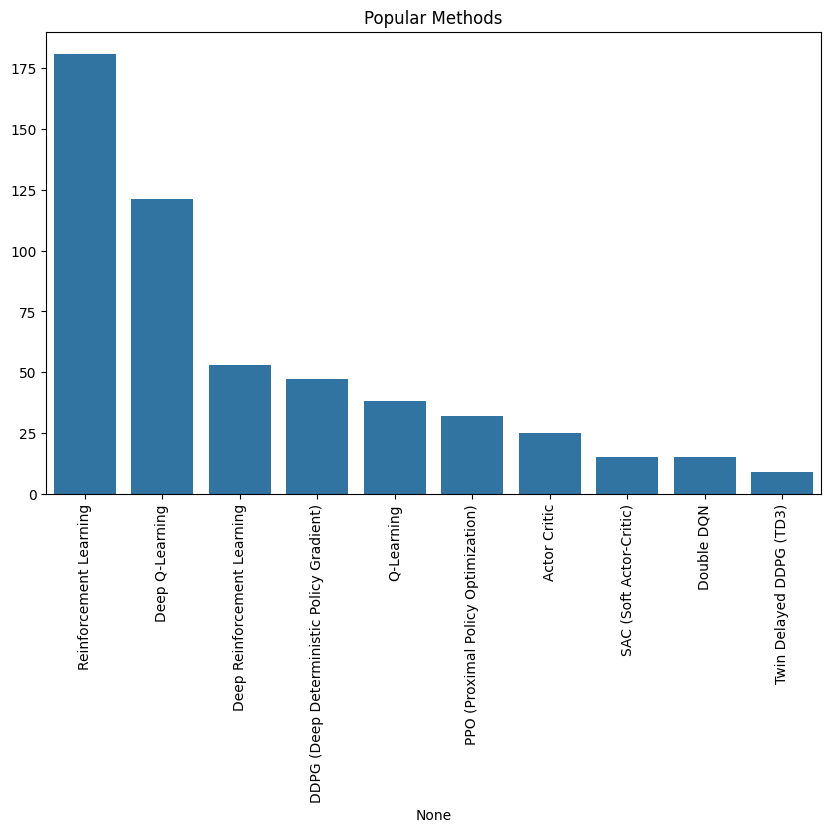

Domain: Behavior Decision, Count: 159
Domain: Traffic Efficiency, Count: 148
Domain: Motion Planning, Count: 94
Domain: Vehicle-to-Everything (V2X) Communication, Count: 59
Domain: Energy Management, Count: 19
Domain: Velocity Control, Count: 13
Domain: Trajectory Optimization, Count: 12
Domain: Lateral Control, Count: 10
Domain: Dynamic Obstacle Avoidance, Count: 9
Domain: Risk Assessment, Count: 6


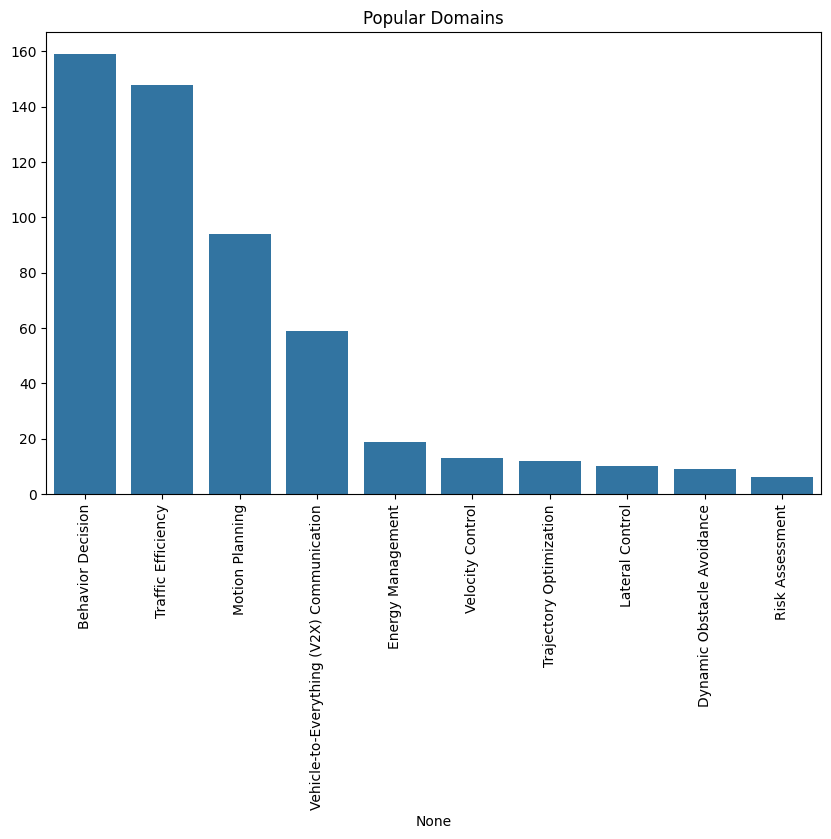

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# 提取方法和领域的信息
methods = []
domains = []
for paper in papers:
    if paper.methods != 'Not Specified':
        methods.append(paper.methods)
        domains.append(paper.domains)

# 计算每种方法和领域的出现次数
method_counts = pd.Series(methods).value_counts()
domain_counts = pd.Series(domains).value_counts()

# 绘制热门方法的图表
plt.figure(figsize=(10, 6))
sns.barplot(x=method_counts.head(10).index, y=method_counts.head(10).values)
plt.title('Popular Methods')
plt.xticks(rotation=90)
plt.show()

# 绘制热门领域的图表
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=domain_counts.head(10).index, y=domain_counts.head(10).values)
plt.title('Popular Domains')
plt.xticks(rotation=90)

# 打印每个领域的文章数量
for domain, count in zip(domain_counts.head(10).index, domain_counts.head(10).values):
    print(f"Domain: {domain}, Count: {count}")

plt.show()



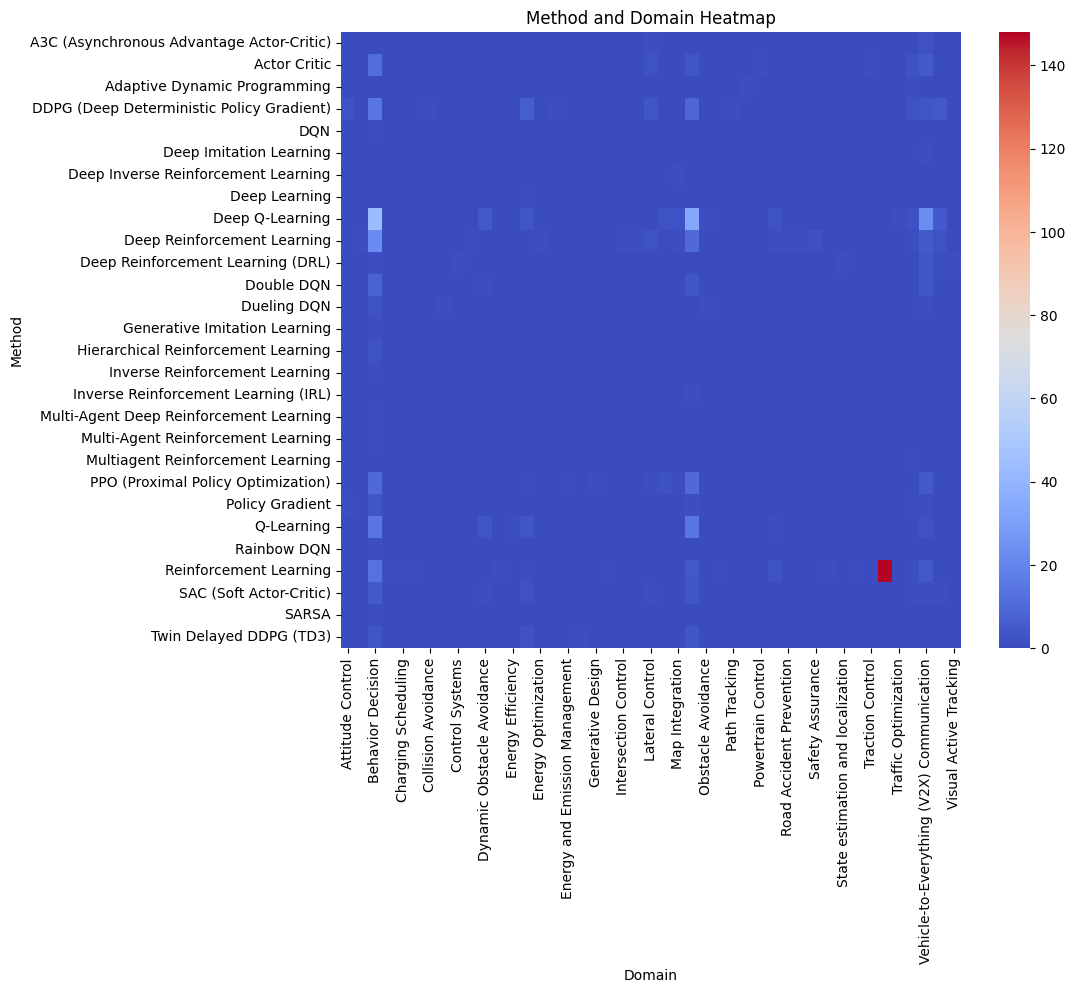

In [11]:
#我们可以画出一个domain-method棋盘图：

import seaborn as sns
import matplotlib.pyplot as plt

# 创建一个数据框来存储方法和领域的组合
df = pd.DataFrame({'Method': methods, 'Domain': domains})
df['Count'] = 1
df = df.groupby(['Method', 'Domain']).count().reset_index()

# 使用方法和领域的出现次数来筛选数据
df = df[df['Method'].isin(method_counts.index) & df['Domain'].isin(domain_counts.index)]

# 创建一个透视表
pivot_table = df.pivot_table(values='Count', index='Method', columns='Domain', fill_value=0)

# 创建热图
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='coolwarm')
plt.title('Method and Domain Heatmap')
plt.xlabel('Domain')
plt.ylabel('Method')
plt.show()

## IF&cites update
为papers添加IF和cites信息

废弃了 各个网页API都不好用，爬几次就被ban了

建议下文献集的时候直接加上IF和cites信息，或者根据cites排序


## RAG

在此基础上，可以通过这些论文的标题摘要建立知识库。当然也可以之后选取更高引、高IF、优质论文作为RAG数据库。
这个过程会先把知识库数据向量化，然后建立索引。在使用时通过查询来检索知识库中的数据，整合到prompt中。

> RAG is a technique for augmenting LLM knowledge with additional data.
>
> LLMs can reason about wide-ranging topics, but their knowledge is limited to the public data up to a specific point in time that they were trained on. If you want to build AI applications that can reason about private data or data introduced after a model’s cutoff date, you need to augment the knowledge of the model with the specific information it needs. The process of bringing the appropriate information and inserting it into the model prompt is known as Retrieval Augmented Generation (RAG).

![RAG](document/RAG_file_indexing.jpg)

![RAG](document/Retrieval%20and%20generation.jpg)



In [ ]:
from llm_chain import get_paper_RAG_chain_txt
rag_chain = get_paper_RAG_chain_txt(papers,llmconfig)

In [16]:
domain_now = 'Dynamic Control'

In [17]:
rag_chain.invoke("What are the main advantages for RL when RL used in the domain of " + domain_now + "?")

'The main advantages of RL in the domain of Dynamic Control include superior learning performance, near-optimal control performance, and the ability to handle uncertainties related to vehicle dynamics and environmental dynamics.'

In [18]:
rag_chain.invoke("What are the main challenges when RL used in the domain of " + domain_now + "?")

'The main challenges when RL is used in the domain of Dynamic Control include the sample complexity of DRL methods, the need for successful transfer from simulation to reality, and the lack of simulators addressing central RL research tasks within autonomous driving.'

pdfs RAG

In [ ]:
from llm_chain import get_rag_chain, generate_vectors_pdf, get_llm_rag_answer

knowledge_files = ['literature_pdf\\Advanced planning for autonomous vehicles using reinforcement.pdf']
vector = generate_vectors_pdf(llmconfig, knowledge_files)
llmchain = get_rag_chain(llmconfig)

In [ ]:
question = "Why the autor use DRL for automotive motion planning?"
result = get_llm_rag_answer(llmchain, vector, question)

## SQL
papers是以tab delimited file的形式导入的，也就是CSV，存储格式也是类似的。可以通过SQL查询来检索数据

![SQL](document/agent_SQL.jpg)

In [14]:
from llm_chain import get_chain_paper_sql
csv_file = "output\\savedrecs_UDRL_SortCitations_tagged.txt"
sql_chain = get_chain_paper_sql(llmconfig, csv_file)

In [25]:
domain_now = 'Velocity Control and Lateral Control'

In [26]:
sql_chain.invoke({"input": f"select papers in domain of {domain_now}, just give me their dio, first Author and method, in table format."})



> Entering new SQL Agent Executor chain...

Invoking: `sql_db_list_tables` with `{}`


papers
Invoking: `sql_db_schema` with `{'table_names': 'papers'}`



CREATE TABLE papers (
	publication_type TEXT, 
	authors TEXT, 
	title TEXT, 
	publication_year TEXT, 
	publication_name TEXT, 
	conference_name TEXT, 
	start_page TEXT, 
	end_page TEXT, 
	abstract TEXT, 
	document_type TEXT, 
	publication_date TEXT, 
	doi TEXT, 
	method TEXT, 
	domain TEXT
)

/*
3 rows from papers table:
publication_type	authors	title	publication_year	publication_name	conference_name	start_page	end_page	abstract	document_type	publication_date	doi	method	domain
C	Ma, Zibo; Liu, Xudong; Zhang, Liguo	Dissipation of Stop-and-Go Waves of Mixed Autonomous Vehicle Flow with Reinforcement Learning	2021	2021 PROCEEDINGS OF THE 40TH CHINESE CONTROL CONFERENCE (CCC)	Chinese Control Conference	6064	6069	Traffic congestion is a common phenomenon in cities, and improving traffic efficiency has become an 	Proceedings Paper	2021	

{'input': 'select papers in domain of Velocity Control and Lateral Control, just give me their dio, first Author and method, in table format.',
 'output': 'Based on the schema of the "papers" table, I can query for the DOI, first author, and method of papers in the domain of Velocity Control and Lateral Control. Here is the SQL query to retrieve the desired information:\n\n```sql\nSELECT doi AS "DOI", \n       SUBSTR(authors, 1, INSTR(authors, \';\') - 1) AS "First Author", \n       method AS "Method"\nFROM papers\nWHERE domain IN (\'Velocity Control\', \'Lateral Control\')\nLIMIT 10;\n```\n\nThis query selects the DOI, extracts the first author from the "authors" column, and retrieves the method from the "method" column. It filters the results based on the specified domains and limits the output to a maximum of 10 rows.\n\nPlease note that the actual execution of the query may return different results depending on the data in the database.'}